 # Tidy Data

> Structuring datasets to facilitate analysis [(Wickham 2014)](http://www.jstatsoft.org/v59/i10/paper)

The one thing I want to impress is that your tools shouldn't get in the way of your analysis. Your problem is already difficult enough, don't let the data or your tools make it any harder.

Tidy Data (and the closely related topic of reshaping data) is a way of structuring your data and APIs in a consistent (sensible) way to make things flow more smoothly.

## The Rules

In a tidy dataset...

1. Each variable forms a column
2. Each observation forms a row

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white", context="talk")
plt.rcParams['figure.figsize'] = 12, 8
pd.options.display.max_rows = 10
%matplotlib inline

Earlier, I fetched some data

```python
tables = pd.read_html("http://www.basketball-reference.com/leagues/NBA_2016_games.html")
games = tables[0]
games.to_csv('data/games.csv', index=False)
```

In [2]:
!head -n  5 data/games.csv

Date,Start (ET),Unnamed: 2,Visitor/Neutral,PTS,Home/Neutral,PTS.1,Unnamed: 7,Notes
October,,,,,,,,
"Tue, Oct 27, 2015",8:00 pm,Box Score,Detroit Pistons,106.0,Atlanta Hawks,94.0,,
"Tue, Oct 27, 2015",8:00 pm,Box Score,Cleveland Cavaliers,95.0,Chicago Bulls,97.0,,
"Tue, Oct 27, 2015",10:30 pm,Box Score,New Orleans Pelicans,95.0,Golden State Warriors,111.0,,


So the data is roughly like

| Date        | Visitor Team | Visitor Points | Home Team | Home Points |
| ----------- | ------------ | -------------- | --------- | ----------- |
| 2015-10-07  | Detroit      | 106            | Atlanta   | 94          |
| ...         | ...          | ...            | ...       | ...         |

Plus some extra junk.

[The Question](http://stackoverflow.com/questions/22695680/python-pandas-timedelta-specific-rows):
> **How many days of rest did each team get between each game?**

Whether or not your dataset is tidy depends on your question. Given our question, Is our data tidy? What is an observation?

---
<a href="#answer" class="btn btn-default" data-toggle="collapse">Show Answer</a>
<div id="answer" class="collapse">
An observation is a (team, game) pair. So no, we don't have a tidy dataset.
A tidy dataset would be like

<table>
<thead>
<tr class="header">
<th>Date</th>
<th>Team</th>
<th>Home / Away</th>
<th>Points</th>
</tr>
</thead>
<tbody>
<tr class="odd">
<td>2015-10-07</td>
<td>Detroit</td>
<td>Away</td>
<td>106</td>
</tr>
<tr class="even">
<td>2015-10-07</td>
<td>Atlanta</td>
<td>Home</td>
<td>94</td>
</tr>
<tr class="odd">
<td>...</td>
<td>...</td>
<td>...</td>
<td>...</td>
</tr>
</tbody>
</table>

</div>




Let's do a bit of general cleaning to remove that extra junk before reshaping the data to be tidy.

In [3]:
column_names = {'Date': 'date', 'Start (ET)': 'start',
                'Unamed: 2': 'box', 'Visitor/Neutral': 'away_team', 
                'PTS': 'away_points', 'Home/Neutral': 'home_team',
                'PTS.1': 'home_points', 'Unamed: 7': 'n_ot'}

games = (
    pd.read_csv("data/games.csv")
      .rename(columns=column_names)
      .dropna(thresh=4)
      [['date', 'away_team', 'away_points', 'home_team', 'home_points']]
      .assign(date=lambda x: pd.to_datetime(x['date'], format='%a, %b %d, %Y'))
      .set_index('date', append=True)
      .rename_axis(["game_id", "date"])
      .sort_index()
)
games.head()

,,away_team,away_points,home_team,home_points
game_id,date,,,,
1,2015-10-27,Detroit Pistons,106.0,Atlanta Hawks,94.0
2,2015-10-27,Cleveland Cavaliers,95.0,Chicago Bulls,97.0
3,2015-10-27,New Orleans Pelicans,95.0,Golden State Warriors,111.0
4,2015-10-28,Philadelphia 76ers,95.0,Boston Celtics,112.0
5,2015-10-28,Chicago Bulls,115.0,Brooklyn Nets,100.0


Above, we saw that we need to collapse the away / home teams down to two columns: one identifier and one for the value. Likewise with the points.
We'll also need to repeat the metadata fields, like the date and `game_id`, so that each observation is matched with the correct date. `pd.melt` does all this for us.

In [4]:
tidy = pd.melt(games.reset_index(),
               id_vars=['game_id', 'date'], value_vars=['away_team', 'home_team'],
               value_name='team').sort_values(['game_id', 'date'])

tidy.head()

,game_id,date,variable,team
0,1,2015-10-27,away_team,Detroit Pistons
1230,1,2015-10-27,home_team,Atlanta Hawks
1,2,2015-10-27,away_team,Cleveland Cavaliers
1231,2,2015-10-27,home_team,Chicago Bulls
2,3,2015-10-27,away_team,New Orleans Pelicans


Now the translation from question to operation is direct:

In [5]:
# How many days of rest for each team?
# For each team...  get number of days between games
tidy.groupby('team')['date'].diff().dt.days - 1

0       NaN
1230    NaN
1       NaN
1231    NaN
2       NaN
       ... 
2457    1.0
1228    2.0
2458    3.0
1229    1.0
2459    1.0
Name: date, dtype: float64

In [6]:
tidy['rest'] = tidy.groupby('team').date.diff().dt.days - 1
tidy.dropna().head()

,game_id,date,variable,team,rest
4,5,2015-10-28,away_team,Chicago Bulls,0.0
1235,6,2015-10-28,home_team,Detroit Pistons,0.0
8,9,2015-10-28,away_team,Cleveland Cavaliers,0.0
14,15,2015-10-28,away_team,New Orleans Pelicans,0.0
17,18,2015-10-29,away_team,Memphis Grizzlies,0.0


You can "invert" a `melt` with `pd.pivot_table`

In [7]:
by_game = (pd.pivot_table(tidy, values='rest',
                          index=['game_id', 'date'],
                          columns='variable')
             .rename(columns={'away_team': 'away_rest',
                              'home_team': 'home_rest'})
             .rename_axis(None, axis='columns'))
by_game.dropna().head()

,,away_rest,home_rest
game_id,date,,
18,2015-10-29,0.0,0.0
19,2015-10-29,0.0,0.0
20,2015-10-29,1.0,0.0
21,2015-10-30,1.0,0.0
22,2015-10-30,1.0,1.0


`concat` will merge two dataframes, expanding an `axis`, while aligning on the other axis.

In [8]:
df = pd.concat([games, by_game], axis='columns')
df.head()

,,away_team,away_points,home_team,home_points,away_rest,home_rest
game_id,date,,,,,,
1,2015-10-27,Detroit Pistons,106.0,Atlanta Hawks,94.0,NaN,NaN
2,2015-10-27,Cleveland Cavaliers,95.0,Chicago Bulls,97.0,NaN,NaN
3,2015-10-27,New Orleans Pelicans,95.0,Golden State Warriors,111.0,NaN,NaN
4,2015-10-28,Philadelphia 76ers,95.0,Boston Celtics,112.0,NaN,NaN
5,2015-10-28,Chicago Bulls,115.0,Brooklyn Nets,100.0,0.0,NaN


So now we have two datasets

- `tidy`: For team-level questions
- `df`: For game-level questions

Even though I called one of the variables `tidy`, both datasets are tidy in their own way, it just depends on the question your trying to answer.

For example, let's say we wanted to look at the rest durations, split by home/away, faceted by team. We'd use `tidy` for that since it's a team-level question.

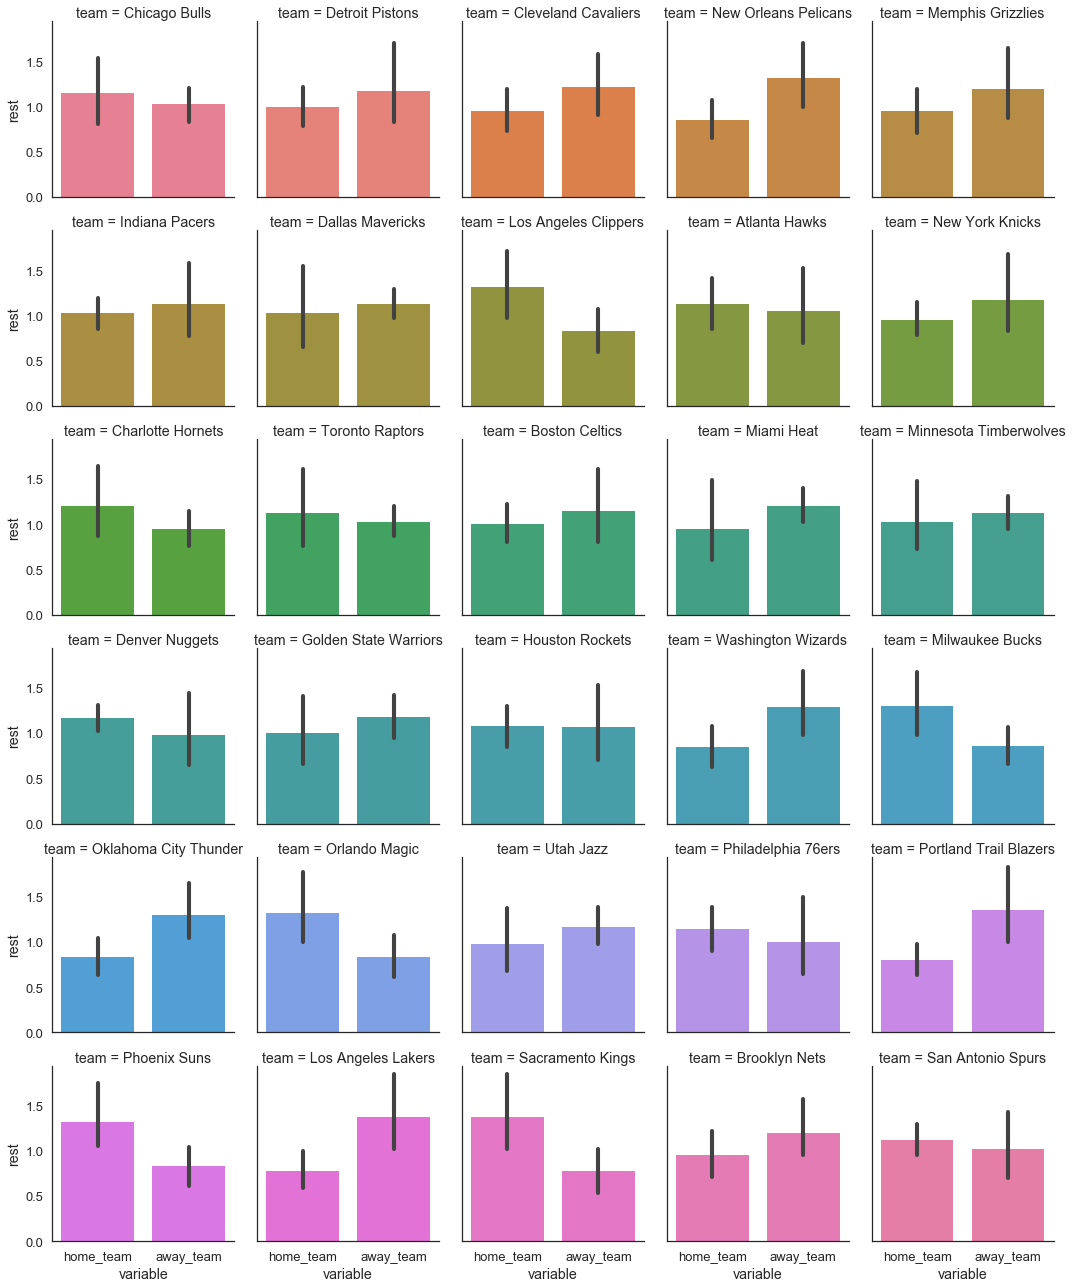

In [9]:
g = sns.FacetGrid(data=tidy.dropna(), col='team', col_wrap=5, hue='team')
g.map(sns.barplot, "variable", "rest");

If we wanted to look at the distribution of the *differences* in rest, we'd use `df` since the difference is a game-level statistic.

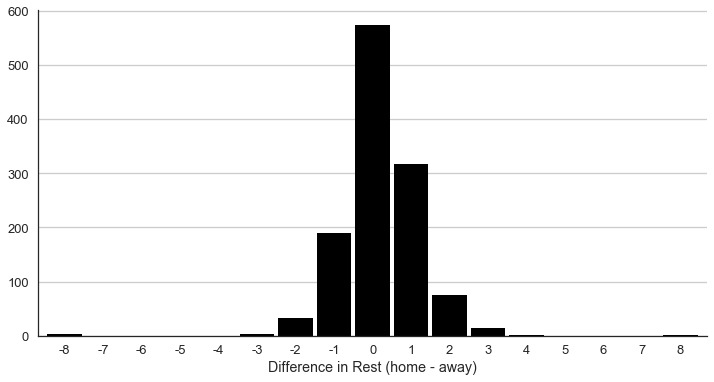

In [10]:
delta = (df['home_rest'] - df['away_rest']).dropna().astype(int)
(delta.value_counts()
    .reindex(np.arange(delta.min(), delta.max() + 1), fill_value=0)
    .sort_index().plot(kind='bar', color='k', width=.9, rot=0, figsize=(12, 6)))
sns.despine()
plt.xlabel("Difference in Rest (home - away)")
plt.grid(axis='y');

<div class="alert alert-success">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise</h1>
</div>

Find the win-percent for each team, by whether they're home or away.

Hints:

- You'll need a new variable for `winning_team` (use `np.where`?)
- You'll need to `melt` that along with the home / away columns (which column is `id_vars`? Which columns are `value_vars`?)
- A tidy dataset looks like

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>winning_team</th>
      <th>home_or_away</th>
      <th>team</th>
      <th>won</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>Detroit Pistons</td>
      <td>away_team</td>
      <td>Detroit Pistons</td>
      <td>True</td>
    </tr>
    <tr>
      <th>1</th>
      <td>Chicago Bulls</td>
      <td>away_team</td>
      <td>Cleveland Cavaliers</td>
      <td>False</td>
    </tr>
    <tr>
      <th>2</th>
      <td>Golden State Warriors</td>
      <td>away_team</td>
      <td>New Orleans Pelicans</td>
      <td>False</td>
    </tr>
    <tr>
      <th>3</th>
      <td>Boston Celtics</td>
      <td>away_team</td>
      <td>Philadelphia 76ers</td>
      <td>False</td>
    </tr>
    <tr>
      <th>4</th>
      <td>Chicago Bulls</td>
      <td>away_team</td>
      <td>Chicago Bulls</td>
      <td>True</td>
    </tr>
  </tbody>
</table>

- With the tidy dataset we can `groupby` and take the mean. Teams play the same number of home and away games, so a simple (un-weighted) average will work.



In [11]:
# %load solutions/tidy_00.py
df['winning_team'] = np.where(
    df.home_points > df.away_points,
    df.home_team,
    df.away_team)

win = pd.melt(df, id_vars='winning_team', value_vars=['away_team', 'home_team'],
              var_name='home_or_away', value_name='team')
win['won'] = win.winning_team == win.team
win_pct = win.groupby(['team', 'home_or_away']).won.mean()
win_pct.head()


team            home_or_away
Atlanta Hawks   away_team       0.512195
                home_team       0.658537
Boston Celtics  away_team       0.487805
                home_team       0.682927
Brooklyn Nets   away_team       0.170732
Name: won, dtype: float64

# Stack / Unstack

The exact shape of a tidy dataset depends on the question being asked.
Additionally, not all APIs expect tidy data, so you need to convert between "wide" and "long" form data.

In [12]:
rest = (tidy.groupby(['date', 'variable'])
            .rest.mean()
            .dropna())
rest.head()

date        variable 
2015-10-28  away_team    0.000000
            home_team    0.000000
2015-10-29  away_team    0.333333
            home_team    0.000000
2015-10-30  away_team    1.083333
Name: rest, dtype: float64

`rest` is in "long" form. `DataFrame.plot` for example, expects wide form data.

In [13]:
rest.unstack().head()

variable,away_team,home_team
date,,
2015-10-28,0.000000,0.000000
2015-10-29,0.333333,0.000000
2015-10-30,1.083333,0.916667
2015-10-31,0.166667,0.833333
2015-11-01,1.142857,1.000000


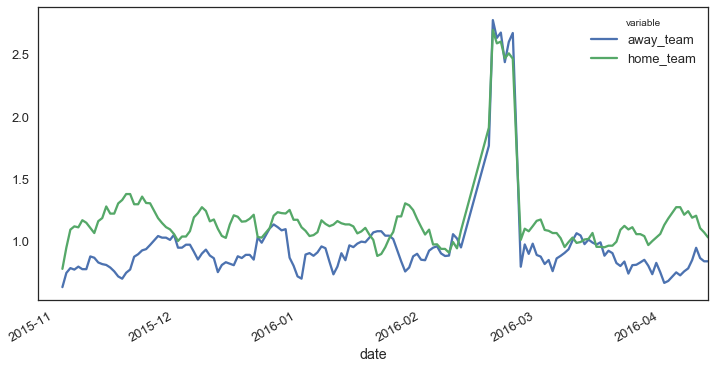

In [14]:
rest.unstack().rolling(7).mean().plot(figsize=(12, 6));

# Aside: Tidy Data & APIs

There are two sides to the tidy data coin:

1. As a user, consistent way of storing, thinking about your data. Make use of APIs written for tidy data
2. As a *library author* you can design APIs that will work across datasets

In [15]:
import logging
import coloredlogs

logger = logging.getLogger(__name__)
coloredlogs.install("INFO")

In [16]:
trains = pd.read_csv('data/trains.csv', index_col=0)
trains.head()

,choiceid,choice,price1,time1,change1,comfort1,price2,time2,change2,comfort2
id,,,,,,,,,,
1,1,choice1,2400,150,0,1,4000,150,0,1
1,2,choice1,2400,150,0,1,3200,130,0,1
1,3,choice1,2400,115,0,1,4000,115,0,0
1,4,choice2,4000,130,0,1,3200,150,0,0
1,5,choice2,2400,150,0,1,3200,150,0,0


Suppose you had this hypothetical ETL pipeline, and you wanted to follow a couple design rules

- Each function does exactly one step in the transformation
- Each function returns a (transformed) *tidy* DataFrame

This won't work for every job, but it can cover a lot of cases.

In [17]:
def fetch():
    return pd.read_csv('data/trains.csv', index_col=0)

def filter_time(trains):
    return trains[trains.time1 < trains.time2]

def similar_cost(trains, max_difference=1000):
    return trains[np.abs(trains.price1 - trains.price2) < max_difference]

def by_choice(trains):
    cols = ['price1', 'time1', 'change1', 'comfort1', 'price2', 'time2',
            'change2', 'comfort2']
    return trains.groupby('choice')[cols].mean()

To use that, we can write code like

In [18]:
data = (fetch()
    .pipe(filter_time)
    .pipe(similar_cost, max_difference=500)
    .pipe(by_choice))
data

,price1,time1,change1,comfort1,price2,time2,change2,comfort2
choice,,,,,,,,
choice1,3177.491409,116.446735,0.752577,0.920962,3149.656357,136.652921,0.611684,0.797251
choice2,3117.052402,116.301310,0.768559,1.131004,3047.401747,133.362445,0.524017,0.567686


This is reasonably clear, but it can be a bit difficult to inspect the inner stages. Suppose you wanted to track the size of the DataFrame through these steps.
One option would be to write a small function like `log_shape(df: DataFrame) -> DataFrame`.

In [19]:
def log_shape(df):
    logger.info(df.shape)
    return df

It passes through the DataFrame untouched, after logging its shape.
You'd incorporate that into the pipeline by inserting it between each "real" ETL step.

In [20]:
data = (fetch()
    .pipe(filter_time)
    .pipe(log_shape)
    .pipe(similar_cost)
    .pipe(log_shape)
    .pipe(by_choice)
    .pipe(log_shape))
data

2016-10-16 10:26:58 MG00085.local __main__[52009] INFO (1127, 10)
2016-10-16 10:26:58 MG00085.local __main__[52009] INFO (936, 10)
2016-10-16 10:26:58 MG00085.local __main__[52009] INFO (2, 8)


,price1,time1,change1,comfort1,price2,time2,change2,comfort2
choice,,,,,,,,
choice1,3328.971861,116.696970,0.722944,0.915584,3262.629870,136.562771,0.640693,0.826840
choice2,3356.497890,115.729958,0.691983,1.033755,3046.529536,132.983122,0.569620,0.704641


This is OK, but not great. We've almost doubled the length of the pipeline; tt's harded to pick out what the pipeline is doing now that there's the extra `log_shape` noise. Additionally, if you have many things you want to check on each output, you'll have to either

1. Make a "super"-logger function that records everything (which violates our preference for each function doing exactly one thing)
2. Insert a `pipe` for each logging function, which grows your pipeline linearly with the number of logging functions.

Fortunately, there's a better way, using decorators.

In [21]:
from functools import wraps

def log_shape(func):
    @wraps(func)
    def deco(*args, **kwargs):
        result = func(*args, **kwargs)
        logger.info("In %s [%s]", func.__name__, result.shape)
        return result
    return deco

So `log_shape` takes a function that returns a DataFrame (or anything with a `.shape` attribute really, and returns a function that's does the first function and logs the output shape.

There are two ways to use decorator functions in python:

In [22]:
log_shape(filter_time)(trains)

2016-10-16 10:26:59 MG00085.local __main__[52009] INFO In filter_time [(1127, 10)]


,choiceid,choice,price1,time1,change1,comfort1,price2,time2,change2,comfort2
id,,,,,,,,,,
1,4,choice2,4000,130,0,1,3200,150,0,0
1,6,choice2,4000,115,0,0,2400,130,0,0
1,8,choice2,2400,115,0,1,3200,150,0,0
1,9,choice1,4000,115,0,0,3200,130,0,1
2,1,choice1,2975,108,0,0,3500,121,0,1
...,...,...,...,...,...,...,...,...,...,...
235,8,choice1,2550,65,0,1,2550,75,1,0
235,10,choice1,2100,55,1,1,2100,75,0,1
235,12,choice1,2550,55,2,1,2550,65,0,1


Or more commonly, use the `@deco` syntax to replace the original function with the decorated version.

In [23]:
@log_shape
def fetch():
    return pd.read_csv('data/trains.csv', index_col=0)

@log_shape
def filter_time(trains):
    return trains[trains.time1 < trains.time2]

@log_shape
def similar_cost(trains):
    return trains[np.abs(trains.price1 - trains.price2) < 1000]

@log_shape
def by_choice(trains):
    cols = ['price1', 'time1', 'change1', 'comfort1', 'price2', 'time2',
            'change2', 'comfort2']
    return trains.groupby('choice')[cols].mean()

In [24]:
data = (fetch()
    .pipe(filter_time)
    .pipe(similar_cost)
    .pipe(by_choice))
data

2016-10-16 10:26:59 MG00085.local __main__[52009] INFO In fetch [(2929, 10)]
2016-10-16 10:26:59 MG00085.local __main__[52009] INFO In filter_time [(1127, 10)]
2016-10-16 10:27:00 MG00085.local __main__[52009] INFO In similar_cost [(936, 10)]
2016-10-16 10:27:00 MG00085.local __main__[52009] INFO In by_choice [(2, 8)]


,price1,time1,change1,comfort1,price2,time2,change2,comfort2
choice,,,,,,,,
choice1,3328.971861,116.696970,0.722944,0.915584,3262.629870,136.562771,0.640693,0.826840
choice2,3356.497890,115.729958,0.691983,1.033755,3046.529536,132.983122,0.569620,0.704641


<div class="alert alert-success">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise</h1>
</div>

Reproducing [this](http://www.nessis.org/nessis07/Dylan_Small.pdf).

What's the effect (in terms of probability to win) of being
the home team?
What are the components of the advantage?

If your DataFrame is out of sync, you might want to load in a fresh one,

```python
df = pd.read_csv('data/tidy_checkpoint.csv', parse_dates=['date'],
                 index_col=['game_id', 'date'])
```

Our final dataframe will have one row per game (like `df`).
Most examples I've seen use a "team strength" variable in their regression estimating the home court advantage. We'll grab one from ESPN.

## Step 0: Outcome variable

In [27]:
# %load solutions/tidy_01.py
df['home_win'] = df.home_points > df.away_points
df['point_spread'] = df.home_points - df.away_points
df.head()


,,away_team,away_points,home_team,home_points,away_rest,home_rest,winning_team,home_win,point_spread
game_id,date,,,,,,,,,
1,2015-10-27,Detroit Pistons,106.0,Atlanta Hawks,94.0,NaN,NaN,Detroit Pistons,False,-12.0
2,2015-10-27,Cleveland Cavaliers,95.0,Chicago Bulls,97.0,NaN,NaN,Chicago Bulls,True,2.0
3,2015-10-27,New Orleans Pelicans,95.0,Golden State Warriors,111.0,NaN,NaN,Golden State Warriors,True,16.0
4,2015-10-28,Philadelphia 76ers,95.0,Boston Celtics,112.0,NaN,NaN,Boston Celtics,True,17.0
5,2015-10-28,Chicago Bulls,115.0,Brooklyn Nets,100.0,0.0,NaN,Chicago Bulls,False,-15.0


In [28]:
df.home_win.mean()

0.58861788617886179

Use RPI from prior year: http://www.espn.com/nba/stats/rpi/_/year/2015 as a measure of team strength

```python
rpi = pd.read_html("http://www.espn.com/nba/stats/rpi/_/year/2015")[0]
```

In [29]:
raw_rpi = pd.read_csv("data/rpi.csv")
raw_rpi.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,2014-15 NBA RPI Rankings,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,RK,TEAM,RPI,W,L,PCT,SOS,PWR,PF,PA,EWL,EWP
2,1,Golden State,.582,67,15,.817,.504,1,9016,8188,68-14,.831
3,2,Houston,.552,56,26,.683,.509,7,8522,8240,52-30,.635
4,NaN,LA,.552,56,26,.683,.509,4,8751,8211,61-21,.741


In [30]:
rpi_cols = raw_rpi.loc[1]
rpi = (
    raw_rpi.drop([0, 1])
       .rename(columns={str(i): v for i, v in enumerate(rpi_cols)})
       .set_index("TEAM")
       .assign(RPI=lambda x: pd.to_numeric(x.RPI))
)
rpi.head()

,RK,RPI,W,L,PCT,SOS,PWR,PF,PA,EWL,EWP
TEAM,,,,,,,,,,,
Golden State,1,0.582,67,15,.817,.504,1,9016,8188,68-14,.831
Houston,2,0.552,56,26,.683,.509,7,8522,8240,52-30,.635
LA,NaN,0.552,56,26,.683,.509,4,8751,8211,61-21,.741
Atlanta,4,0.551,60,22,.732,.491,5,8409,7964,58-24,.710
Memphis,5,0.549,55,27,.671,.509,8,8062,7796,52-30,.635


Merge `df` and `rpi` on team.

In [31]:
mapping = dict(zip(
    sorted(rpi.index),
    sorted(set(df.away_team.unique()))
))
mapping

{'Atlanta': 'Atlanta Hawks',
 'Boston': 'Boston Celtics',
 'Brooklyn': 'Brooklyn Nets',
 'Charlotte': 'Charlotte Hornets',
 'Chicago': 'Chicago Bulls',
 'Cleveland': 'Cleveland Cavaliers',
 'Dallas': 'Dallas Mavericks',
 'Denver': 'Denver Nuggets',
 'Detroit': 'Detroit Pistons',
 'Golden State': 'Golden State Warriors',
 'Houston': 'Houston Rockets',
 'Indiana': 'Indiana Pacers',
 'LA': 'Los Angeles Clippers',
 'LA Lakers': 'Los Angeles Lakers',
 'Memphis': 'Memphis Grizzlies',
 'Miami': 'Miami Heat',
 'Milwaukee': 'Milwaukee Bucks',
 'Minnesota': 'Minnesota Timberwolves',
 'New Orleans': 'New Orleans Pelicans',
 'New York': 'New York Knicks',
 'Oklahoma City': 'Oklahoma City Thunder',
 'Orlando': 'Orlando Magic',
 'Philadelphia': 'Philadelphia 76ers',
 'Phoenix': 'Phoenix Suns',
 'Portland': 'Portland Trail Blazers',
 'Sacramento': 'Sacramento Kings',
 'San Antonio': 'San Antonio Spurs',
 'Toronto': 'Toronto Raptors',
 'Utah': 'Utah Jazz',
 'Washington': 'Washington Wizards'}

Create two new columns

- `home_strength`
- `away_strength`

Using either `.map` or `pd.merge`

In [33]:
# %load solutions/tidy_02.py
# RPI
df['home_strength'] = df.home_team.map(rpi.rename(mapping)['RPI'])
df['away_strength'] = df.away_team.map(rpi.rename(mapping)['RPI'])
df.head()


,,away_team,away_points,home_team,home_points,away_rest,home_rest,winning_team,home_win,point_spread,home_strength,away_strength
game_id,date,,,,,,,,,,,
1,2015-10-27,Detroit Pistons,106.0,Atlanta Hawks,94.0,NaN,NaN,Detroit Pistons,False,-12.0,0.551,0.467
2,2015-10-27,Cleveland Cavaliers,95.0,Chicago Bulls,97.0,NaN,NaN,Chicago Bulls,True,2.0,0.523,0.535
3,2015-10-27,New Orleans Pelicans,95.0,Golden State Warriors,111.0,NaN,NaN,Golden State Warriors,True,16.0,0.582,0.517
4,2015-10-28,Philadelphia 76ers,95.0,Boston Celtics,112.0,NaN,NaN,Boston Celtics,True,17.0,0.490,0.425
5,2015-10-28,Chicago Bulls,115.0,Brooklyn Nets,100.0,0.0,NaN,Chicago Bulls,False,-15.0,0.487,0.523


Create a new column `d_rest` that contains the difference in rest (home - away)

In [36]:
# %load solutions/tidy_03.py
df['d_rest'] = df['home_rest'] - df['away_rest']
df.head()


,,away_team,away_points,home_team,home_points,away_rest,home_rest,winning_team,home_win,point_spread,home_strength,away_strength,d_rest
game_id,date,,,,,,,,,,,,
1,2015-10-27,Detroit Pistons,106.0,Atlanta Hawks,94.0,NaN,NaN,Detroit Pistons,False,-12.0,0.551,0.467,NaN
2,2015-10-27,Cleveland Cavaliers,95.0,Chicago Bulls,97.0,NaN,NaN,Chicago Bulls,True,2.0,0.523,0.535,NaN
3,2015-10-27,New Orleans Pelicans,95.0,Golden State Warriors,111.0,NaN,NaN,Golden State Warriors,True,16.0,0.582,0.517,NaN
4,2015-10-28,Philadelphia 76ers,95.0,Boston Celtics,112.0,NaN,NaN,Boston Celtics,True,17.0,0.490,0.425,NaN
5,2015-10-28,Chicago Bulls,115.0,Brooklyn Nets,100.0,0.0,NaN,Chicago Bulls,False,-15.0,0.487,0.523,NaN


Remove rows with missing values (rest), fixup a dtype for statsmodels

In [37]:
df = df.dropna()
df.loc[:, 'home_win'] = df['home_win'].astype(int)
df.head()

,,away_team,away_points,home_team,home_points,away_rest,home_rest,winning_team,home_win,point_spread,home_strength,away_strength,d_rest
game_id,date,,,,,,,,,,,,
18,2015-10-29,Memphis Grizzlies,112.0,Indiana Pacers,103.0,0.0,0.0,Memphis Grizzlies,0,-9.0,0.484,0.549,0.0
19,2015-10-29,Dallas Mavericks,88.0,Los Angeles Clippers,104.0,0.0,0.0,Los Angeles Clippers,1,16.0,0.552,0.536,0.0
20,2015-10-29,Atlanta Hawks,112.0,New York Knicks,101.0,1.0,0.0,Atlanta Hawks,0,-11.0,0.419,0.551,-1.0
21,2015-10-30,Charlotte Hornets,94.0,Atlanta Hawks,97.0,1.0,0.0,Atlanta Hawks,1,3.0,0.551,0.471,-1.0
22,2015-10-30,Toronto Raptors,113.0,Boston Celtics,103.0,1.0,1.0,Toronto Raptors,0,-10.0,0.490,0.517,0.0


Let's do a bit of viz to see if we're on the right track.
Bar plot of home win percent  by the difference in rest.

If our suspicions are true we'd expect a positive relationship between `d_rest` and `home_win`.

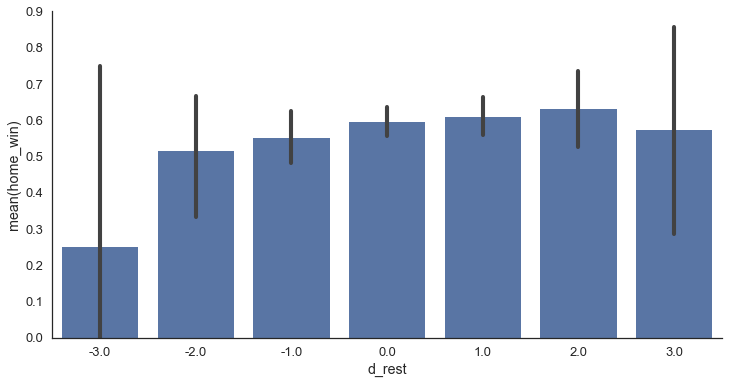

In [39]:
# %load solutions/tidy_04.py
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='d_rest', y='home_win',
            data=df.loc[(-3 <= df.d_rest) &
                        (df.d_rest <= 3)],
            color='#4c72b0', ax=ax)
sns.despine()


Another way of viewing the home-court advantage: a slope-graph of each team's home and away win percents.

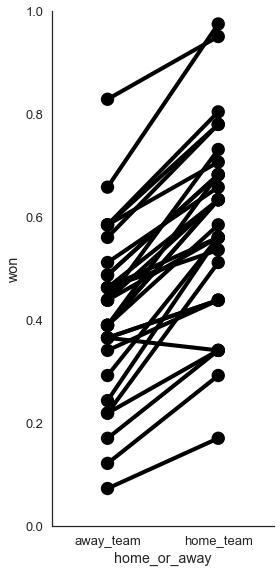

In [40]:
g = sns.FacetGrid(win_pct.reset_index(), hue='team', size=8, aspect=.5, palette=['k'])
g.map(sns.pointplot, 'home_or_away', 'won').set(ylim=(0, 1));

Now we can fit the model

In [41]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [42]:
df.head()

,,away_team,away_points,home_team,home_points,away_rest,home_rest,winning_team,home_win,point_spread,home_strength,away_strength,d_rest
game_id,date,,,,,,,,,,,,
18,2015-10-29,Memphis Grizzlies,112.0,Indiana Pacers,103.0,0.0,0.0,Memphis Grizzlies,0,-9.0,0.484,0.549,0.0
19,2015-10-29,Dallas Mavericks,88.0,Los Angeles Clippers,104.0,0.0,0.0,Los Angeles Clippers,1,16.0,0.552,0.536,0.0
20,2015-10-29,Atlanta Hawks,112.0,New York Knicks,101.0,1.0,0.0,Atlanta Hawks,0,-11.0,0.419,0.551,-1.0
21,2015-10-30,Charlotte Hornets,94.0,Atlanta Hawks,97.0,1.0,0.0,Atlanta Hawks,1,3.0,0.551,0.471,-1.0
22,2015-10-30,Toronto Raptors,113.0,Boston Celtics,103.0,1.0,1.0,Toronto Raptors,0,-10.0,0.490,0.517,0.0


In [43]:
mod = smf.ols('point_spread ~ d_rest + home_strength + away_strength', data=df)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           point_spread   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     54.28
Date:                Sun, 16 Oct 2016   Prob (F-statistic):           6.48e-33
Time:                        10:18:32   Log-Likelihood:                -4783.6
No. Observations:                1213   AIC:                             9575.
Df Residuals:                    1209   BIC:                             9596.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -6.5106      6.147     -1.059      0.290     -18.571       5.550
d_rest            0.3939      0.341      1.155      0.248      -0.275       1.063
home_strength    85.5022      8.604      9.938      0.000      68.622     102.382
away_strength   -67.1119      8.617     -7.789      0.000     -84.017     -50.207
==============================================================================
Omnibus:                        6.326   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.042   Jarque-Bera (JB):                7.183
Skew:                           0.093   Prob(JB):                       0.0276
Kurtosis:                       3.328   Cond. No.                         37.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
m = smf.mixedlm("point_spread ~ d_rest", df, groups=df['home_team'],
                re_formula="~home_strength")
res = m.fit()
res.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Mixed Linear Model Regression Results
============================================================================
Model:                  MixedLM       Dependent Variable:       point_spread
No. Observations:       1213          Method:                   REML        
No. Groups:             30            Scale:                    151.2493    
Min. group size:        40            Likelihood:               -4792.0880  
Max. group size:        41            Converged:                Yes         
Mean group size:        40.4                                                
----------------------------------------------------------------------------
                                  Coef.   Std.Err.   z   P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                           2.897    1.073 2.701 0.007  0.795  4.999
d_rest                              0.354    0.337 1.051 0.293 -0.307  1.016
Intercept RE                     2146.402  103.461                          
Intercept RE x home_strength RE -4246.104  205.319                          
home_strength RE                 8440.240  408.027                          
============================================================================

"""

Back to back games on the road? We'll need a counter for each team that resets when they play a home game.

When developing complicated groupby functions, I like to grab and individual group and prototype on that:

In [45]:
gr = tidy.groupby('team').variable
v = gr.get_group("Chicago Bulls")
v.head()

1231    home_team
4       away_team
24      away_team
1269    home_team
52      away_team
Name: variable, dtype: object

In [47]:
# %load solutions/tidy_05.py
def compute_away_streaks(v):
    is_away = v == 'away_team'
    season_away = is_away.cumsum()
    # Need to "reset" that count each time they go home
    home_games = v[~is_away].index
    # Subtract the `season_away` value for the prior away leg
    home_offset = pd.Series(season_away, index=home_games)
    offset = (home_offset
        .reindex(season_away.index)
        .fillna(method='ffill'))
    return season_away - offset


Now use `compute_away_streaks` to make a `Series` away_streaks; Recall that we prototyped on a single group, and that the output of `compute_away_streaks` should have the same shape as the input.

In [50]:
# %load solutions/tidy_06.py
# fill 1 for teams that start on the road
away_streaks = (
    tidy.groupby("team")
        .variable
        .transform(compute_away_streaks).fillna(1))
away_streaks.head()


0       1.0
1230    0.0
1       1.0
1231    0.0
2       1.0
Name: variable, dtype: float64

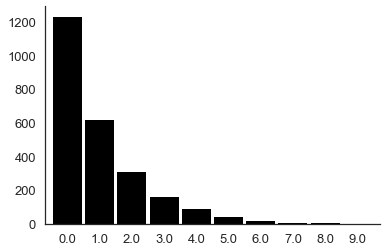

In [51]:
away_streaks.value_counts().plot.bar(color='k', width=.9, rot=0)
sns.despine();

In [52]:
tidy['away_streak'] = away_streaks
tidy.head()

,game_id,date,variable,team,rest,away_streak
0,1,2015-10-27,away_team,Detroit Pistons,NaN,1.0
1230,1,2015-10-27,home_team,Atlanta Hawks,NaN,0.0
1,2,2015-10-27,away_team,Cleveland Cavaliers,NaN,1.0
1231,2,2015-10-27,home_team,Chicago Bulls,NaN,0.0
2,3,2015-10-27,away_team,New Orleans Pelicans,NaN,1.0


In [54]:
game_away_streak = (
    pd.pivot_table(
        tidy, values='away_streak', index=['game_id', 'date'],
        columns='variable'
    ).rename(columns={'away_team': 'away_streak'}))['away_streak']
df['game_away_streak'] = game_away_streak

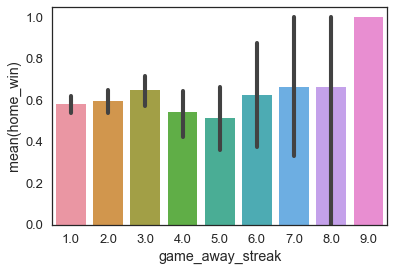

In [55]:
sns.barplot('game_away_streak', 'home_win', data=df);

In [56]:
m = smf.mixedlm("point_spread ~ d_rest + game_away_streak", df, groups=df['home_team'],
                re_formula="~home_strength + away_strength")
res = m.fit()
res.summary()

/Users/tom.augspurger/miniconda3/envs/uni/lib/python3.5/site-packages/statsmodels/base/model.py:475: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Mixed Linear Model Regression Results
================================================================================
Model:                    MixedLM        Dependent Variable:        point_spread
No. Observations:         1213           Method:                    REML        
No. Groups:               30             Scale:                     144.6156    
Min. group size:          40             Likelihood:                -4777.6674  
Max. group size:          41             Converged:                 Yes         
Mean group size:          40.4                                                  
--------------------------------------------------------------------------------
                                      Coef.   Std.Err.   z   P>|z| [0.025 0.975]
--------------------------------------------------------------------------------
Intercept                               5.202    2.662 1.954 0.051 -0.015 10.419
d_rest                                  0.421    0.333 1.261 0.207 -0.233  1.074
game_away_streak                        0.301    0.273 1.104 0.270 -0.234  0.837
Intercept RE                          134.748   71.684                          
Intercept RE x home_strength RE      -548.610  134.911                          
home_strength RE                     4489.203  338.183                          
Intercept RE x away_strength RE       254.484   72.544                          
home_strength RE x away_strength RE -3744.297  166.999                          
away_strength RE                     3732.475  125.488                          
================================================================================

"""

# Recap

- Tidy data: one row per observation
    - melt / stack: wide to long
    - pivot_table / unstack: long to wide